New functions for generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sys
import os
import logging
import galsim
import cmath as cm
import math
import random
import scipy
from importlib import reload
from scipy.stats import norm
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
from multiprocess import *
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import plot, utils


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
%run -i ../../scripts/Images_generation/images_generator.py
%run -i ../../scripts/Images_generation/cosmos_generation.py

# Test of recorded images

In [4]:
test = np.load('/sps/lsst/users/barcelin/data/blended_images/28/miscenter/test/galaxies_blended_20191024_0_images.npy', mmap_mode = 'c')

In [5]:
shifts = np.load('/sps/lsst/users/barcelin/data/blended_images/28/miscenter/test/galaxies_blended_20191024_0_shifts.npy')

In [6]:
test.shape

(10000, 2, 10, 64, 64)

In [7]:
bands = [0,1,2,3,4,5,6,7,8,9]
pixel_scale_lsst = 0.2

In [8]:
input_noisy = test[:,0]
input_noiseless = test[:,1]

In [9]:
reload(utils)

<module 'tools_for_VAE.utils' from '../../scripts/tools_for_VAE/tools_for_VAE/utils.py'>

In [10]:
input_noisy = utils.norm(input_noisy, bands,5, inplace = False)
input_noiseless = utils.norm(input_noiseless, bands,5, inplace = False)

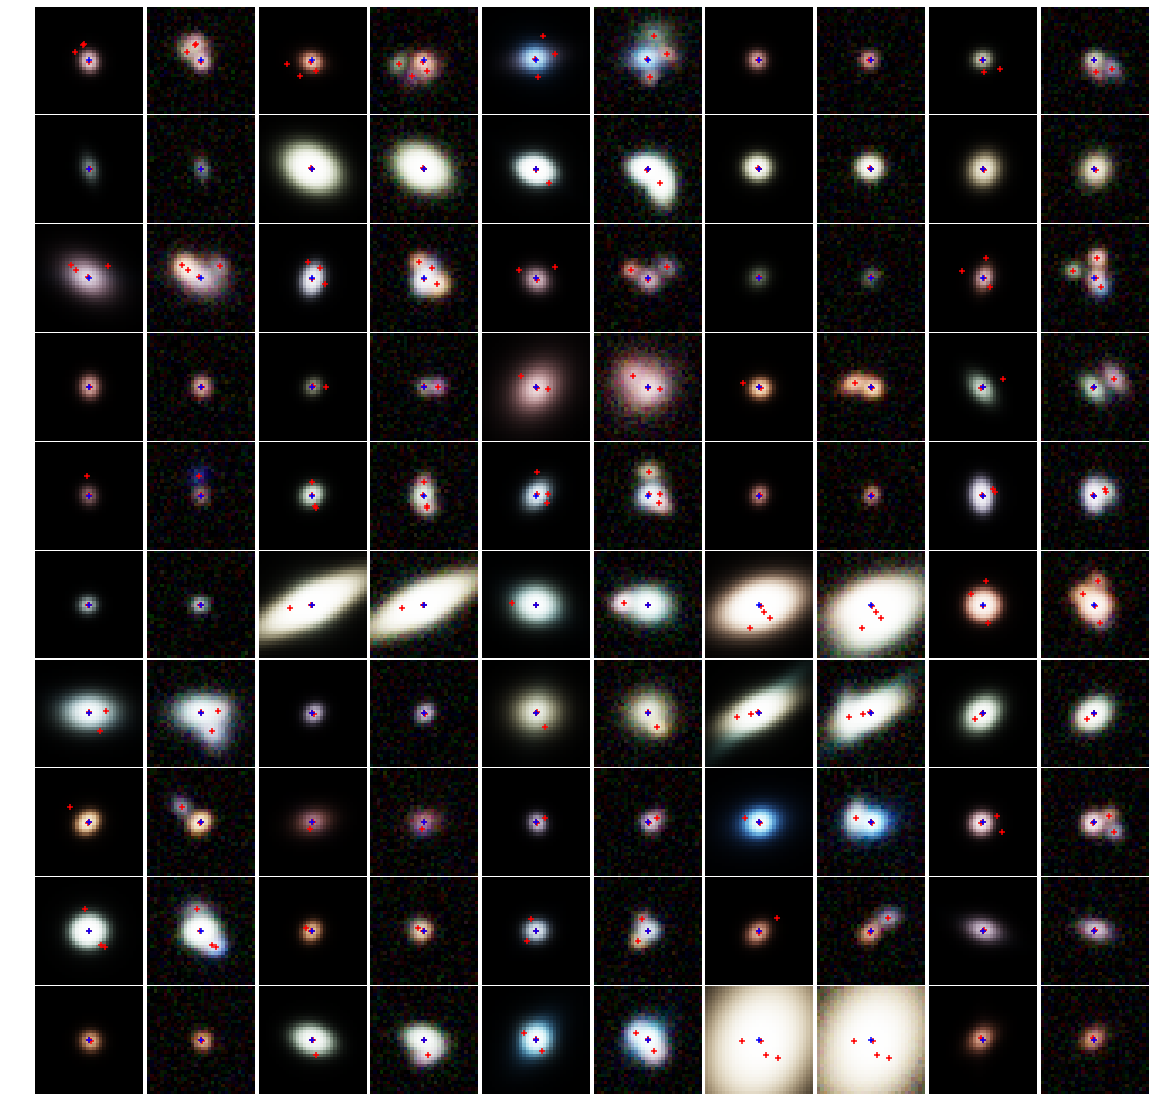

In [12]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):    
        plot.plot_rgb(input_noisy[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        plot.plot_rgb(input_noiseless[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j+1], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')

In [11]:
import astropy
import photutils

In [12]:
from photutils import find_peaks
from astropy.stats import sigma_clipped_stats

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

In [13]:
images = input_noiseless[:10000]

In [14]:
images = utils.denorm(images, bands,5, inplace = False)

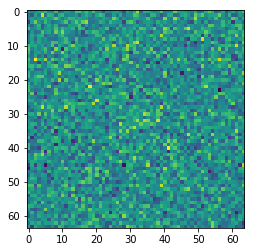

In [273]:
plt.imshow(images[241,6])

In [15]:
mean, median, std = sigma_clipped_stats(images[:,6], sigma=3.0)
threshold = np.sqrt(sky_level_pixel[6])

In [16]:
len(images)

10000

In [42]:
x_peaks = []
y_peaks = []
peaks_values = []

keys = ['idx','x_in','x_peak','x_peak_pix','y_in', 'y_peak','y_peak_pix', 'peak_value','r','r_closest']

df_peaks = pd.DataFrame(index = np.arange(len(images)), columns = keys)
indices = np.arange(len(images))

for i,idx in enumerate (indices):
    df_temp = find_peaks(images[i,6], threshold = median + 5.*std, npeaks = 4, box_size=3)#(median + 5.*std)
    if df_temp is not None:
        df_temp.sort('peak_value', reverse=True)
        r = [np.sqrt((shifts[idx][0,0]-(df_temp['x_peak'][0]-31.5)*0.2)**2+(shifts[idx][0,1]-(df_temp['y_peak'][0]-31.5)*0.2)**2)]
        df_peaks.loc[i] = [idx, shifts[idx][0,0], 
                           (df_temp['x_peak'][0]-31.5)*0.2,
                           df_temp['x_peak'][0],
                           shifts[idx][0,1], 
                           (df_temp['y_peak'][0]-31.5)*0.2,
                           df_temp['y_peak'][0],
                           df_temp['peak_value'][0],
                           r[0],
                           np.min(r)]
    
    else:
        df_peaks.loc[i] = [idx, shifts[idx][0,0], np.nan,np.nan, shifts[idx][0,1], np.nan, np.nan, np.nan, np.nan, np.nan]
df_peaks

,idx,x_in,x_peak,x_peak_pix,y_in,y_peak,y_peak_pix,peak_value,r,r_closest
0,0,0.0153026,0.1,32,0.029538,0.1,32,6475.89,0.110175,0.110175
1,1,0.0580095,0.1,32,-0.0227557,-0.1,31,47880.9,0.0879198,0.0879198
2,2,0.00934518,-0.1,31,0.0372891,-0.1,31,4579.89,0.175513,0.175513
3,3,-0.053094,-0.1,31,0.096127,0.1,32,19950.9,0.0470656,0.0470656
4,4,-0.00675789,-0.1,31,0.0187574,-0.1,31,20767.9,0.150988,0.150988
5,5,0.0985849,0.1,32,-0.0595613,-0.1,31,7514.89,0.0404635,0.0404635
6,6,0.0397115,0.1,32,0.0479586,0.1,32,10204.9,0.079643,0.079643
7,7,0.0271958,0.7,35,0.00033582,0.1,32,6499.89,0.680146,0.680146
8,8,0.0842286,0.1,32,-0.0689269,-0.1,31,14266.9,0.0348464,0.0348464
9,9,0.0294273,-0.1,31,-0.00731303,-0.1,31,4417.89,0.159193,0.159193


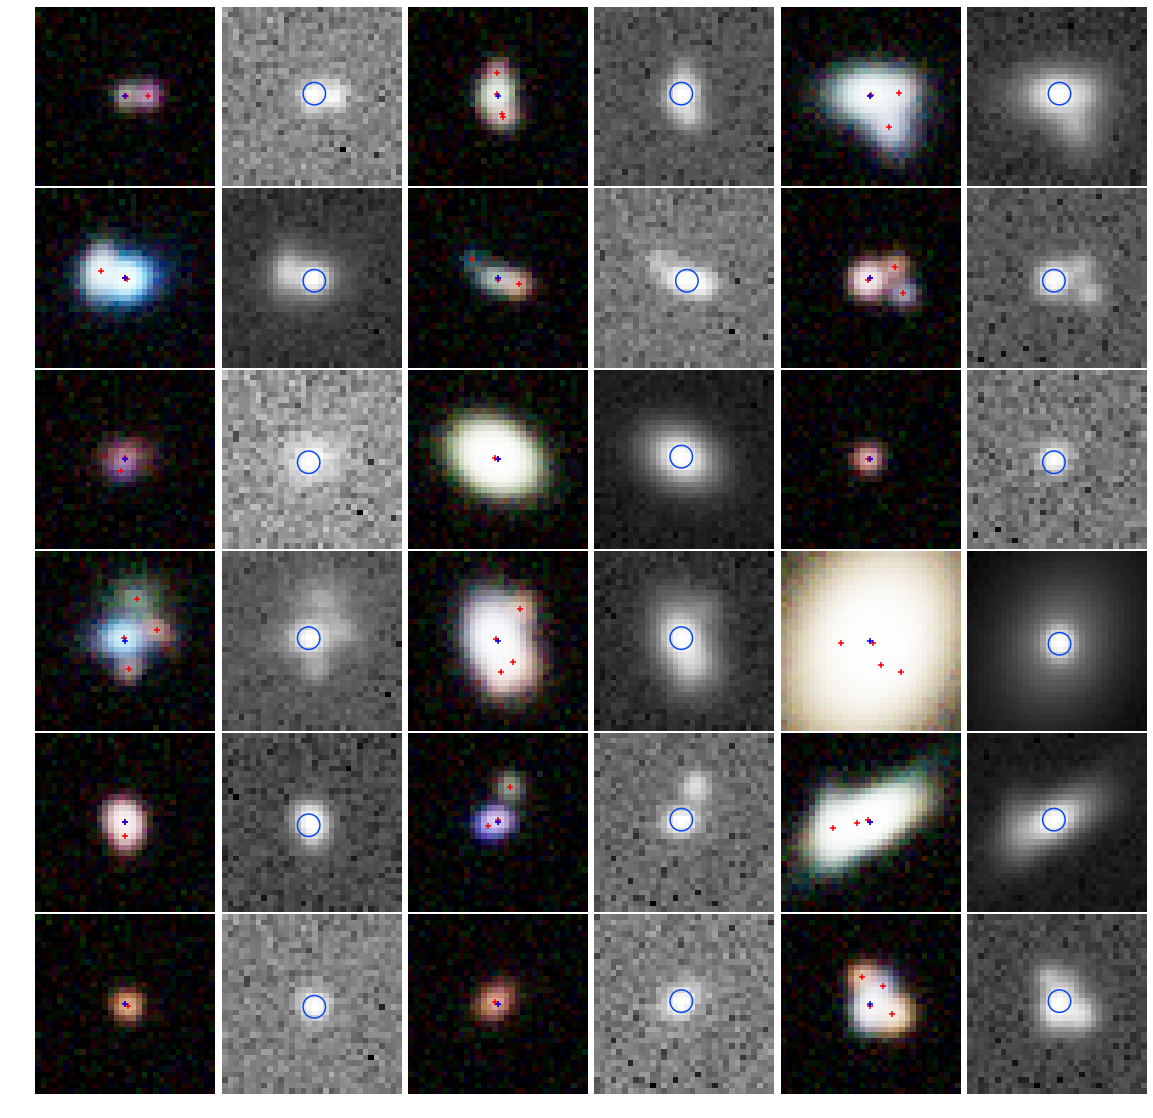

In [18]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.arange(100)#np.random.choice(50, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        
        plot.plot_rgb(input_noiseless[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        
        
        positions = np.transpose((df_peaks['x_peak_pix'][i+j*N_plot]-16, df_peaks['y_peak_pix'][i+j*N_plot]-16))
        apertures = CircularAperture(positions, r=2.)
        norm = simple_norm(images[i+j*N_plot,6,16:48,16:48], 'sqrt', percent=99.9)#,16:48,16:48
        axes[i,j+1].imshow(images[i+j*N_plot,6,16:48,16:48], cmap='Greys_r', origin='lower', norm=norm)
        apertures.plot(color='#0547f9', lw=1.5, axes = axes[i,j+1])
        
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')


ValueError: color kwarg must have one color per data set. 9898 data sets and 1 colors were provided

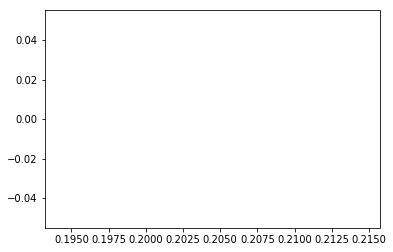

In [41]:
sns.distplot(df_peaks.dropna()['r'])